In [1]:
import torch
from torchinfo import summary

In [2]:
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r

In [3]:
model = HyperMapp3r(dims=3,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=True,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   )

In [4]:
summary(model, (1, 3, 32, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
HyperMapp3r                              --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-3                        --                        --
├─ModuleList: 1-4                        --                        --
├─ModuleList: 1-5                        --                        --
├─ModuleList: 1-2                        --                        --
│    └─Conv3d: 2-1                       [1, 16, 16, 64, 64]       1,312
├─ModuleList: 1-1                        --                        --
│    └─HM3Block: 2-2                     [1, 16, 16, 64, 64]       --
│    │    └─InstanceNorm3d: 3-1          [1, 16, 16, 64, 64]       --
│    │    └─LeakyReLU: 3-2               [1, 16, 16, 64, 64]       --
│    │    └─Conv3d: 3-3                  [1, 16, 16, 64, 64]       6,912
│    │   

In [6]:
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN

SyntaxError: invalid syntax (HyperMapp3r_SSN.py, line 116)

In [59]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple


def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout
    
class HyperMapp3r_SSN(HyperMapp3r):
    def __init__(self, dims=3,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False
                ):
        super().__init__(dims=dims,
                 in_channels=in_channels,
                 out_channels=decoder_features[-1], # last layer of just keeps number of nodes fixed this time
                 encoder_features=encoder_features,
                 decoder_features=decoder_features,
                 softmax=softmax,
                 up_res_blocks=up_res_blocks,
                 block_params=block_params)
        
        print("WARNING: this model assumes that the input to the model contains the brain mask in the first channel!")
        conv_func = get_conv_func(dims, transpose=False)
        self.ssn_rank = ssn_rank
        self.ssn_diagonal = ssn_diagonal
        self.ssn_epsilon = ssn_epsilon
        self.ssn_num_classes = out_channels
        
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.mean_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) *  dims, padding='same')
        self.log_cov_diag_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) * dims, padding='same')
        self.cov_factor_l = conv_func(decoder_features[-1], out_channels * ssn_rank, kernel_size = (1,) * dims, padding='same')

    def forward(self, x):
        logits = self.lrelu(super().forward(x))
        batch_size = logits.shape[0]
        event_shape = (self.ssn_num_classes,) + logits.shape[2:]
        
        mean = self.mean_l(logits)
        mean = mean.view(batch_size, -1)
        
        cov_diag = self.log_cov_diag_l(logits).exp() + self.ssn_epsilon
        cov_diag = cov_diag.view(batch_size, -1)
        
        cov_factor = self.cov_factor_l(logits)
        cov_factor = cov_factor.view(batch_size, self.ssn_rank, self.ssn_num_classes, -1)
        cov_factor = cov_factor.flatten(2,3)
        cov_factor = cov_factor.transpose(1,2)
        
        # covariance tends to blow up to infinity, hence set to 0 outside the ROI
        mask = x[:,1]
        mask = mask.unsqueeze(1).expand((batch_size, self.ssn_num_classes) + mask.shape[1:]).reshape(batch_size, -1)
        cov_factor = cov_factor * mask.unsqueeze(-1)
        cov_diag = cov_diag * mask + self.ssn_epsilon
        
        if self.ssn_diagonal:
            base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)), 1)
        else:
            try:
                base_distribution = td.LowRankMultivariateNormal(loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
            except:
                print('Covariance became non invertible using independent normals for this batch!')
                base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)),1)
                
        distribution = ReshapedDistribution(base_distribution, event_shape)
        
        shape = (batch_size,) + event_shape
        logit_mean_view = mean.view(shape).detach()
        cov_diag_view = cov_diag.view(shape).detach()
        cov_factor_view = cov_factor.transpose(2,1).view((batch_size, self.ssn_num_classes * self.ssn_rank) + event_shape[1:]).detach()
        
        
        output_dict = {
            'logit_mean':logit_mean_view,
            'cov_diag':cov_diag_view,
            'cov_factor':cov_factor_view,
            'distribution':distribution,
        }
        
        return output_dict
    
    
class ReshapedDistribution(td.Distribution):
    def __init__(self, base_distribution: td.Distribution, new_event_shape: Tuple[int, ...]):
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=new_event_shape, validate_args=False)
        self.base_distribution = base_distribution
        self.new_shape = base_distribution.batch_shape + new_event_shape
        
        #print("base distribution: ", self.base_distribution)

    @property
    def support(self):
        return self.base_distribution.support

    @property
    def arg_constraints(self):
        return self.base_distribution.arg_constraints()

    @property
    def mean(self):
        return self.base_distribution.mean.view(self.new_shape)

    @property
    def variance(self):
        return self.base_distribution.variance.view(self.new_shape)

    def rsample(self, sample_shape=torch.Size()):
        return self.base_distribution.rsample(sample_shape).view(sample_shape + self.new_shape)

    def log_prob(self, value):
        return self.base_distribution.log_prob(value.view(self.batch_shape + (-1,)))

    def entropy(self):
        return self.base_distribution.entropy()

In [87]:
model = HyperMapp3rSSN(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False)

In [88]:
summary(model, (1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
HyperMapp3r_SSN                          --                        --
├─ModuleList: 1-1                        --                        --
├─ModuleList: 1-2                        --                        --
├─ModuleList: 1-3                        --                        --
├─ModuleList: 1-4                        --                        --
├─ModuleList: 1-5                        --                        --
├─ModuleList: 1-2                        --                        --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
├─ModuleList: 1-1                        --                        --
│    └─HM3Block: 2-2                     [1, 16, 64, 64]           --
│    │    └─InstanceNorm2d: 3-1          [1, 16, 64, 64]           --
│    │    └─LeakyReLU: 3-2               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-3                  [1, 16, 64, 64]           2,304
│    │    └

In [89]:
ones = torch.randn(1, 3, 128, 128)
ones[:,1,:] = (ones[:,1,:] > 0.5).type(torch.float32)

In [90]:
import matplotlib.pyplot as plt

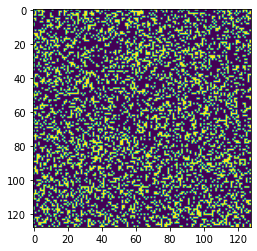

In [91]:
plt.imshow(ones[0][1])

In [92]:
with torch.no_grad():
    result = model(ones.cuda())

In [93]:
result.keys()

dict_keys(['logit_mean', 'cov_diag', 'cov_factor', 'distribution'])

In [94]:
result['logit_mean'].shape

torch.Size([1, 2, 128, 128])

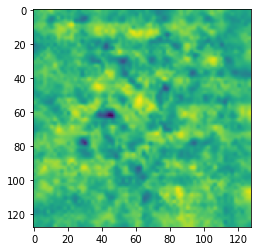

In [106]:
plt.imshow(result['logit_mean'][0][0].cpu())

In [101]:
x = result['distribution']

In [105]:
samples = x.sample_n(12)

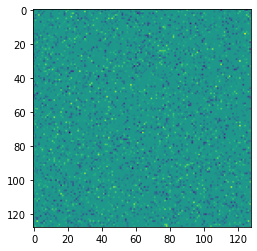

In [117]:
plt.imshow(samples[10][0][0].cpu())